In [2]:
%load_ext autoreload
%autoreload 2
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection

import abstract_gradient_training as agt
from abstract_gradient_training.bounds import interval_bound_propagation as ibp
from abstract_gradient_training import AGTConfig
from models.fully_connected import FullyConnected

# Preliminaries

Set the plotting style, abstract gradient training configuration, prepare the half-moons dataset and initialise the model.

In [3]:
# Set plotting and functional parameters
sns.set_theme(context="poster", style="whitegrid", font_scale=1.45)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

CM = sns.color_palette(palette="Greens", n_colors=12, as_cmap=True)
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
GRIDSIZE = 1000
FIGSIZE = (6, 6)
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=4,
    device="cuda:0",
    forward_bound="interval+crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
)

# Prepare the dataset
X, Y = sklearn.datasets.make_moons(noise=0.1, random_state=0, n_samples=3000)
X[Y==0, 1] += 0.2
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
X_TRAIN = np.hstack((X_TRAIN, X_TRAIN ** 2, X_TRAIN ** 3))
X_TEST = np.hstack((X_TEST, X_TEST ** 2, X_TEST ** 3))
DL = DataLoader(
    dataset=TensorDataset(torch.from_numpy(X_TRAIN).double(), torch.from_numpy(Y_TRAIN)),
    batch_size=BATCHSIZE, shuffle=False
)
DL_TEST = DataLoader(
    dataset=TensorDataset(torch.from_numpy(X_TEST).double(), torch.from_numpy(Y_TEST)),
    batch_size=500, shuffle=False
)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

# Sweep and plotting functions

Define functions for sweeping over a specific AGT config parameter and plotting the results as a contour plot.

In [1]:
def run_sweep(sweep_variable, sweep_values, config):
    """
    For the config parameter with name sweep_variable, run certified training for sweep_variable set to each value
    in sweep_values.
    """
    config = copy.deepcopy(config)
    results = []
    for v in sweep_values:
        config.__setattr__(sweep_variable, v)
        torch.manual_seed(SEED)
        param_l, param_n, param_u = agt.poison_certified_training(MODEL, config, DL, DL_TEST)
        results.append((v, param_l, param_n, param_u))
    return results

def plot_sweep(results, sweep_variable_label):
    """
    Given the parameter bounds in the results list returned from run_sweep, compute the worst-case predictions for a 
    grid of points covering the half-moon dataset and plot the results as a contour plot.
    """
    
    # get the bounds of the dataset for plotting
    x_min, x_max = X_TEST[:, 0].min() - 0.5, X_TEST[:, 0].max() + 0.5
    y_min, y_max = X_TEST[:, 1].min() - 0.5, X_TEST[:, 1].max() + 0.5
    
    # initialise axes
    fig, ax = plt.subplots(figsize=FIGSIZE)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
    
    # define a grid of points to evaluate the model at
    x = torch.linspace(x_min, x_max, GRIDSIZE)
    y = torch.linspace(y_min, y_max, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)
    
    # add polynomial features
    in_data = torch.stack((
        X.flatten(), Y.flatten(),
        X.flatten() ** 2, Y.flatten() ** 2,
        X.flatten() ** 3, Y.flatten() ** 3,
    ), dim=1).unsqueeze(-1).to(NOMINAL_CONFIG.device).double()

    # compute the nominal model predictions
    param_n = results[0][2]
    *_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
    logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
    worst_case_0 = torch.zeros_like(logits)
    worst_case_1 = torch.zeros_like(logits)
    logits = logits.detach().cpu().numpy()
    ax.contour(X, Y, logits, cmap=CM, alpha=1.0, levels=[0.5])

    # for each result in the sweep, compute the worst-case predictions for the entire grid
    for _, param_l, param_n, param_u in results:
        (*_, logits_l), (*_, logits_u)= ibp.bound_forward_pass(param_l, param_u, in_data, in_data)
        worst_case_0 += torch.hstack([logits_l[:, 0], logits_u[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
        worst_case_1 += 1 - torch.hstack([logits_u[:, 0], logits_l[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)

    # plot the worst-case predictions
    worst_case = torch.min(worst_case_0, worst_case_1).detach().cpu().numpy()
    boundaries = list(range(-1, len(results) + 1, 1))
    norm = mpl.colors.Normalize(vmin=worst_case.min(), vmax=worst_case.max())
    ax.contourf(X, Y, worst_case, cmap=CM, norm=norm, alpha=0.8, levels=boundaries)

    # define custom legend
    custom_lines, custom_labels = [], []
    for i in range(len(results)):
        custom_lines.append(mpl.lines.Line2D([0], [0], marker='o', lw=0, markerfacecolor=CM(norm(i+1)), color="grey", alpha=0.8, markersize=15))
        custom_labels.append(f"${sweep_variable_label}={results[i][0]}$")
    custom_labels = custom_labels[::-1]
    ax.legend(custom_lines, custom_labels, loc='upper right', fontsize=22, labelspacing=0.2, handletextpad=0.1, borderpad=0.25)
    
    # plot the test dataset
    ax.scatter(X_TEST[:, 0], X_TEST[:, 1], s=30, c=Y_TEST, edgecolors="k", linewidth=1, cmap=CM_BRIGHT)

## Feature and label poisoning sweep

Sweep over $\epsilon$ values for a fixed $n=m=1$.

Training Batch: 4it [00:02,  1.74it/s, Bound: 0.206 Network eval: Worst=0.9, Nominal=0.93, Best=0.96]  
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.392 Network eval: Worst=0.87, Nominal=0.93, Best=0.98] 
Training Batch: 4it [00:01,  2.61it/s, Bound: 0.542 Network eval: Worst=0.82, Nominal=0.93, Best=0.99] 
Training Batch: 4it [00:01,  2.23it/s, Bound: 0.682 Network eval: Worst=0.76, Nominal=0.93, Best=1]    
/vol/bitbucket/ps1623/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


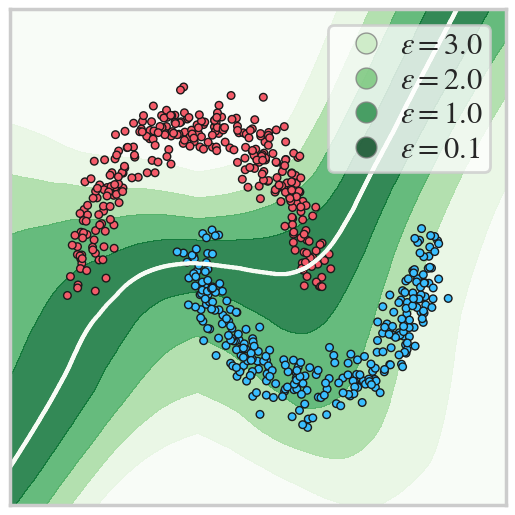

In [4]:
conf = copy.deepcopy(NOMINAL_CONFIG)
conf.label_k_poison = 1
conf.k_poison = 1
results_epsilon_sweep = run_sweep("epsilon", [0.1, 1.0, 2.0, 3.0], conf)
plot_sweep(results_epsilon_sweep, "\epsilon")

## Feature poisoning sweep

Sweep over $\epsilon$ values for a fixed $n=10$.

Training Batch: 1it [00:00,  2.53it/s, Bound: 0.0328 Network eval: Worst=0.84, Nominal=0.84, Best=0.84]

Training Batch: 4it [00:01,  2.58it/s, Bound: 0.25 Network eval: Worst=0.9, Nominal=0.93, Best=0.96]   
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.376 Network eval: Worst=0.87, Nominal=0.93, Best=0.98] 
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.508 Network eval: Worst=0.84, Nominal=0.93, Best=0.99] 
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.637 Network eval: Worst=0.79, Nominal=0.93, Best=1]    


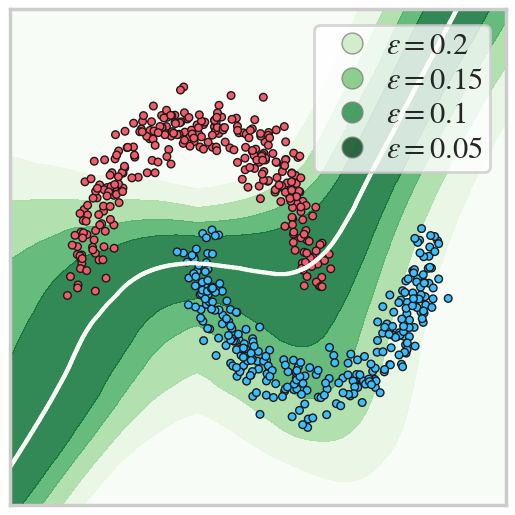

In [5]:
conf = copy.deepcopy(NOMINAL_CONFIG)
conf.k_poison = 10
results_epsilon_sweep = run_sweep("epsilon", [0.05, 0.1, 0.15, 0.2], conf)
plot_sweep(results_epsilon_sweep, "\epsilon")

Sweep over $n$ values for fixed $\epsilon=0.01$.

Training Batch: 4it [00:01,  2.60it/s, Bound: 0.198 Network eval: Worst=0.9, Nominal=0.93, Best=0.96]  
Training Batch: 2it [00:00,  2.61it/s, Bound: 0.128 Network eval: Worst=0.8, Nominal=0.81, Best=0.83]  

Training Batch: 4it [00:01,  2.60it/s, Bound: 0.282 Network eval: Worst=0.89, Nominal=0.93, Best=0.97]
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.433 Network eval: Worst=0.84, Nominal=0.93, Best=0.99] 
Training Batch: 4it [00:01,  2.60it/s, Bound: 0.561 Network eval: Worst=0.78, Nominal=0.93, Best=1]    


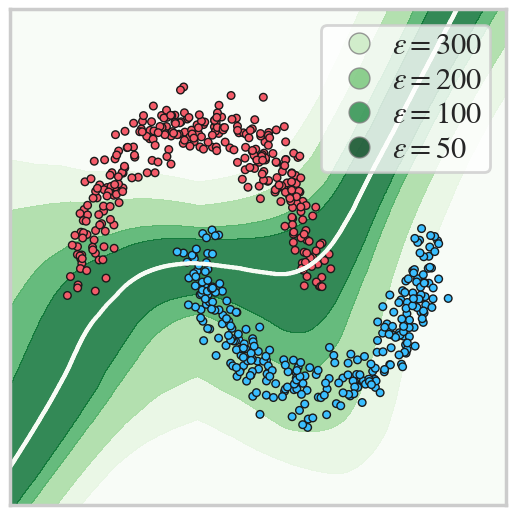

In [6]:
conf = copy.deepcopy(NOMINAL_CONFIG)
conf.epsilon = 0.01
results_epsilon_sweep = run_sweep("k_poison", [50, 100, 200, 300], conf)
plot_sweep(results_epsilon_sweep, "\epsilon")

# Label poisoning sweep

Sweep over $m$ values for a fixed $m=0, \epsilon=0$.

Training Batch: 4it [00:01,  2.32it/s, Bound: 0.189 Network eval: Worst=0.9, Nominal=0.93, Best=0.95] 
Training Batch: 1it [00:00,  2.57it/s, Bound: 0.0217 Network eval: Worst=0.84, Nominal=0.84, Best=0.84]

Training Batch: 4it [00:01,  2.59it/s, Bound: 0.387 Network eval: Worst=0.88, Nominal=0.93, Best=0.98] 
Training Batch: 4it [00:01,  2.59it/s, Bound: 0.595 Network eval: Worst=0.82, Nominal=0.93, Best=0.99] 
Training Batch: 4it [00:01,  2.59it/s, Bound: 0.829 Network eval: Worst=0.75, Nominal=0.93, Best=1]    


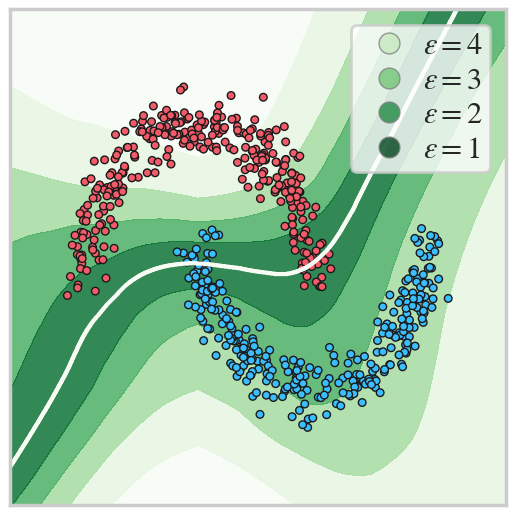

In [7]:
conf = copy.deepcopy(NOMINAL_CONFIG)
results_epsilon_sweep = run_sweep("label_k_poison", [1, 2, 3, 4], conf)
plot_sweep(results_epsilon_sweep, "\epsilon")